For a give set of edges: 
- load edges file
- construct network
- do a bunch of excercises and calculations: 
    - cliques 



In [340]:
import pandas as pd
import networkx as nx
from networkx import centrality
from networkx.algorithms import clique
from networkx.algorithms import core
from networkx.algorithms import traversal

In [325]:
# filename  = 'edges/example1.txt'
filename = 'edges/week5_kcore.txt'

df_edges = pd.read_csv(filename, sep=':', header=None, names=['from', 'to_list'])
df_edges['to_list_split'] = df_edges.to_list.str.strip().str.split(',')
df_edges = df_edges.explode('to_list_split')
# keep hold of nodes with no edges 
add_nodes = df_edges['from'][df_edges.to_list_split.isna()]
# drop incomplete edges 
df_edges.drop(list(add_nodes.index), inplace=True)
# list(df_edges[['from','to_list_split']].itertuples(index=False))
# [tuple(e) for i,e in df_edges[['from','to_list_split']].iterrows()]
# list(zip(df_edges['from'], df_edges['to_list_split']))
edges = [tuple(e) for e in df_edges[['from','to_list_split']].to_records(index=False)]

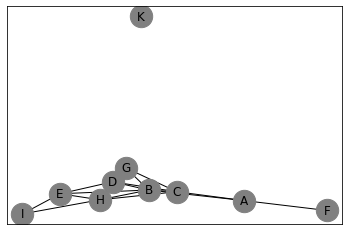

In [326]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(add_nodes)
nx.draw_networkx(G, node_size=500, node_color='grey')

In [327]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 18
Average degree:   3.6000


In [328]:
def get_df(measure, column_name):
    return pd.DataFrame(dict(measure).items(), columns=['node', column_name])

def add_measure(df, measure,column_name): 
    temp = df.join(get_df(measure,column_name),lsuffix='',rsuffix='_r')
    return temp.drop(columns=temp.columns[temp.columns.str.endswith('_r')])

In [329]:
df_measures = pd.DataFrame(list(G.nodes()), columns=['node'])
df_measures

,node
0,A
1,F
2,C
3,B
4,G
5,D
6,H
7,E
8,I
9,K


# add measures 

* clustering coefficient 
* degree
* degree centrality 
* closenness cenrality 
* betweenness cenrality 

In [330]:
df_measures = add_measure(df_measures, nx.clustering(G), 'clustring')
df_measures = add_measure(df_measures, nx.degree(G), 'degree')
df_measures = add_measure(df_measures, centrality.degree_centrality(G), 'degree_centrality')
df_measures = add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')
df_measures['closeness_inv'] = 1/df_measures['closeness_centrality']
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=False), 'betweenness')
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=True), 'betweenness_centrality')
df_measures = add_measure(df_measures, core.core_number(G), 'core')


In [331]:
add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')

,node,clustring,degree,degree_centrality,closeness_centrality,closeness_inv,betweenness,betweenness_centrality,core
0,A,0.333333,3,0.333333,0.507937,1.968750,7.000000,0.194444,2
1,F,0.000000,1,0.111111,0.338624,2.953125,0.000000,0.000000,1
2,C,0.700000,5,0.555556,0.646465,1.546875,3.666667,0.101852,4
3,B,0.600000,6,0.666667,0.711111,1.406250,7.000000,0.194444,4
4,G,1.000000,4,0.444444,0.547009,1.828125,0.000000,0.000000,4
5,D,0.800000,5,0.555556,0.592593,1.687500,0.666667,0.018519,4
6,H,0.600000,6,0.666667,0.646465,1.546875,5.000000,0.138889,4
7,E,0.666667,4,0.444444,0.547009,1.828125,1.666667,0.046296,3
8,I,1.000000,2,0.222222,0.418301,2.390625,0.000000,0.000000,2
9,K,0.000000,0,0.000000,0.000000,inf,0.000000,0.000000,0


The core number of a node is the largest value k of a k-core containing that node.

# find all cliques and maximal cliques 

In [332]:

maximal_cliques = [''.join(sorted(c)) for c in clique.find_cliques(G)]
print('maximal cliques')
print(maximal_cliques)

maximal cliques
['AF', 'ABC', 'K', 'BCDGH', 'BDEH', 'EHI']


In [333]:
df_cliques = pd.DataFrame([(len(c), sorted(c), ''.join(sorted(c))) for c in clique.enumerate_all_cliques(G) if len(c) > 2], columns=['clique_size', 'clique_list', 'clique'])
df_cliques['maximal_clique'] = df_cliques.clique.isin(maximal_cliques)
df_cliques.query( "maximal_clique == True")

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, B, C]",ABC,True
14,3,"[E, H, I]",EHI,True
20,4,"[B, D, E, H]",BDEH,True
21,5,"[B, C, D, G, H]",BCDGH,True


In [334]:
df_cliques.query('clique_size == 3')

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, B, C]",ABC,True
1,3,"[B, C, G]",BCG,False
2,3,"[B, C, D]",BCD,False
3,3,"[B, C, H]",BCH,False
4,3,"[C, D, G]",CDG,False
5,3,"[C, G, H]",CGH,False
6,3,"[C, D, H]",CDH,False
7,3,"[B, D, G]",BDG,False
8,3,"[B, G, H]",BGH,False
9,3,"[B, D, H]",BDH,False


# k-core

In [335]:
print('maximal k-core with k = ', max(df_measures.core), ': ', ''.join(sorted([k for k in core.k_core(G)])))

maximal k-core with k =  4 :  BCDGH


In [338]:
k = 3
''.join(sorted(df_measures.query(f'core >= {k}')['node']))

'BCDEGH'

In [357]:
[c for c in nx.isolates(G)]

['K']

# network traversal: BFS and DFS

In [352]:
start_node = 'A'

In [353]:
print(f'BFS traversal start at {start_node}: ', ' '.join([b for b in traversal.bfs_tree(G, start_node)]))

BFS traversal start at A:  A F C B H G D E I


In [354]:
print(f'DFS traversal start at {start_node}: ', ' '.join([b for b in traversal.dfs_tree(G, start_node)]))

DFS traversal start at A:  A F C B G H E D I
